# Neural networks from scratch

## Libraries and dataset

In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

n_classes = 3
n_loops = 1
n_samples = 1500

def spirals(n_classes=3, n_samples=1500, n_loops=2):
    klass = np.random.choice(n_classes, n_samples)
    radius = np.random.rand(n_samples)
    theta = klass * 2 * math.pi / n_classes + radius * 2 * math.pi * n_loops
    radius = radius + 0.05 * np.random.randn(n_samples)
    return np.column_stack((radius * np.cos(theta), radius * np.sin(theta))).astype("float32"), klass

X, y = spirals(n_samples=n_samples, n_classes=n_classes, n_loops=n_loops)

## Visualize the dataset

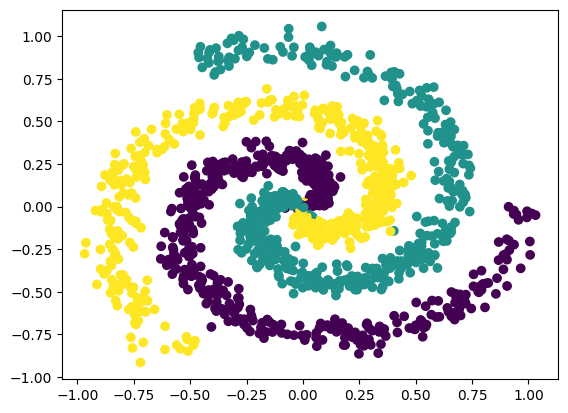

In [8]:
plt.scatter(X[:, 0], X[:, 1], c=y)

## Activation functions

ReLU and sigmoid function and their derivative (should work for numpy
array of any dimension (1D, 2D,…))

In [22]:
def relu(v):
    return np.maximum(0, v)


def drelu(v):
    return np.where(v <= 0, 0, 1)


def sigmoid(v):
    return 1 / (1 + np.exp(-v)) 


def dsigmoid(v):
    return np.exp(-v) / (1 + np.exp(-v))**2



## Defining the neural network

First define the shape of the neural network:

-   `n0`: size of input,
-   `n1`: size of hidden layer,
-   `n2`: size of output.

In [21]:
n0 = X.shape[1]
n1 = 128
n2 = n_classes

Variables for weights, biases of each layers and intermediate variables
to compute the gradient.

In [23]:
# Random weights
W1 = np.random.randn(n0, n1)
W2 = np.random.randn(n1, n2)

# Biases set to zero
b1 = np.zeros(n1)
b2 = np.zeros(n2)

# Partial derivatives of output w.r.t. activations, see slide
# "Backpropagation equations"
Xx_1 = np.zeros((n2, n1))
Xx_2 = np.zeros((n2, n2))

# Partial derivatives of output w.r.t. biases, see slide
# "Backpropagation equations"
Xb_1 = np.zeros((n2, n1))
Xb_2 = np.zeros((n2, n2))

# Partial derivatives of output w.r.t. weights, see slide
# "Backpropagation equations"
Xw_1 = np.zeros((n2, n0, n1))
Xw_2 = np.zeros((n2, n1, n2))

# Partial derivatives of loss w.r.t. weights and biases, see slide
# "Cross entropy loss"
Lw_1 = np.zeros((n0, n1))
Lw_2 = np.zeros((n1, n2))
Lb_1 = np.zeros(n1)
Lb_2 = np.zeros(n2)

Define the learning rate and the activation functions along their
derivatives at each layer:

-   `eta`: learning rate
-   `af`, `daf`: activation function and its derivative for hidden layer

In [20]:
# Define eta, af, daf
eta = 0.1
af = relu
daf = drelu

## The learning loop

In [24]:
nepochs = 15
for epoch in range(nepochs + 1):
    acc_epoch = 0
    for idx, (x0, y2) in enumerate(zip(X, y)):
        # Implement the forward pass: use `W1`, `x0`, `b1`, `af`, `W2`, `x1`,
        # `b2` to define `z1`, `x1`, `z2`. Instead of a second activation
        # function, we will use a softmax transformation to define `x2`.
        z1 = W1.T @ x0 + b1
        x1 = af(z1)
        z2 = W2.T @ x1 + b2
        x2 = np.exp(z2) / np.sum(np.exp(z2))

        # Predicted class
        pred = np.argmax(x2)
        acc_epoch += (pred == y2)

        if idx % 100 == 0:
            print(f"Epoch: {epoch:02}, sample: {idx:04}, class: {y2}, pred: {pred}, prob: {x2}")

        # To initialize the recurrent relation (3), see slide
        # "Backpropagation equations"
        Xx_2 = np.eye(n2)

        # Update partial derivatives of output w.r.t. weights and biases on
        # second layer. Pay attention, it is the last layer so there is no
        # activation function.
        for i in range(n2):
            for p in range(n2):
                # See equation (2) in slide "Backpropagation equations"
                Xb_2[i, p] = Xx_2[i, p]
                for q in range(n1):
                    # See equation (1) in slide "Backpropagation equations"
                    Xw_2[i, q, p] = Xx_2[i, p] * x1[q]

        # Update partial derivatives of output w.r.t. output of hidden layer
        for i in range(n2):
            for p in range(n1):
                Xx_1[i, p] = 0
                for j in range(n2):
                    # See equation (3) in slide "Backpropagation equations"
                    Xx_1[i, p] += Xx_2[i, j] * W2[p, j]

        # Update partial derivatives of output w.r.t. weights and
        # biases of hidden layer
        for i in range(n2):
            for p in range(n1):
                # See equation (2) in slide "Backpropagation equations"
                Xb_1[i, p] = Xx_1[i, p] * daf(z1[p])
                for q in range(n0):
                    # See equation (1) in slide "Backpropagation equations"
                    Xw_1[i, q, p] = Xx_1[i, p] * daf(z1[p]) * x0[q]

        # One-hot encoding of class `y2`
        y2_one_hot = np.zeros(n2)
        y2_one_hot[y2] = 1

        # Compute partial derivatives of the loss w.r.t weights and
        # biases.
        for p in range(n2):
            for q in range(n1):
                Lw_2[q, p] = 0
                for i in range(n2):
                    # Partial derivatives of cross-entropy loss w.r.t.
                    # weights, see slide "Cross-entropy loss"
                    Lw_2[q, p] += (x2[i] - y2_one_hot[i]) * Xw_2[i, q, p]

        for p in range(n1):
            for q in range(n0):
                Lw_1[q, p] = 0
                for i in range(n2):
                    # Partial derivatives of cross-entropy loss w.r.t.
                    # weights, see slide "Cross-entropy loss"
                    Lw_1[q, p] += (x2[i] - y2_one_hot[i]) * Xw_1[i, q, p]

        for p in range(n2):
            Lb_2[p] = 0
            for i in range(n2):
                # Partial derivatives of cross-entropy loss w.r.t.
                # biases, see slide "Cross-entropy loss"
                Lb_2[p] += (x2[i] - y2_one_hot[i]) * Xb_2[i, p]

        for p in range(n1):
            Lb_1[p] = 0
            for i in range(n2):
                # Partial derivatives of cross-entropy loss w.r.t.
                # biases, see slide "Cross-entropy loss"
                Lb_1[p] += (x2[i] - y2_one_hot[i]) * Xb_1[i, p]

        # Gradient descent step: use `eta`, `Lw_1` `Lw_2` `Lb_1` `Lb_2` to
        # update `W1`, `W2`, `b1`, `b2`.
        W1 -= eta * Lw_1
        W2 -= eta * Lw_2
        b1 -= eta * Lb_1
        b2 -= eta * Lb_2

    print(f"Epoch: {epoch:02}, training accuracy: {acc_epoch/n_samples}")

Epoch: 00, sample: 0000, class: 0, pred: 1, prob: [0.02899002 0.91441388 0.0565961 ]
Epoch: 00, sample: 0100, class: 2, pred: 2, prob: [0.2162452  0.37758967 0.40616513]
Epoch: 00, sample: 0200, class: 0, pred: 1, prob: [2.39715283e-03 9.97146248e-01 4.56598892e-04]
Epoch: 00, sample: 0300, class: 2, pred: 1, prob: [0.25078236 0.38000714 0.3692105 ]
Epoch: 00, sample: 0400, class: 1, pred: 1, prob: [0.05837269 0.83921479 0.10241251]
Epoch: 00, sample: 0500, class: 2, pred: 2, prob: [6.21333265e-02 2.72831404e-04 9.37593842e-01]
Epoch: 00, sample: 0600, class: 1, pred: 0, prob: [0.5601306  0.13738515 0.30248425]
Epoch: 00, sample: 0700, class: 0, pred: 0, prob: [9.74450865e-01 2.54082980e-02 1.40837138e-04]
Epoch: 00, sample: 0800, class: 2, pred: 2, prob: [0.19758495 0.02923756 0.7731775 ]
Epoch: 00, sample: 0900, class: 1, pred: 1, prob: [0.11238867 0.76936582 0.1182455 ]
Epoch: 00, sample: 1000, class: 0, pred: 0, prob: [0.6660741  0.08642264 0.24750326]
Epoch: 00, sample: 1100, clas

## Visualization

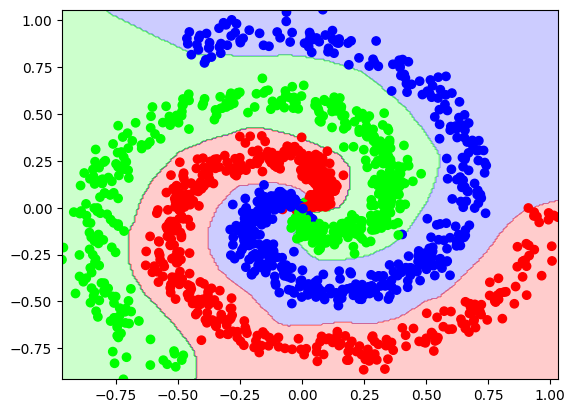

In [25]:
num = 250
xx = np.linspace(X[:, 0].min(), X[:, 0].max(), num)
yy = np.linspace(X[:, 1].min(), X[:, 1].max(), num)
XX, YY = np.meshgrid(xx, yy)
points = np.c_[XX.ravel(), YY.ravel()]

# Forward pass on all points
z1 = W1.T @ points.T + b1[:, np.newaxis]
x1 = af(z1)
z2 = W2.T @ x1 + b2[:, np.newaxis]
x2_hat = np.argmax(z2, axis=0)

C = x2_hat.reshape(num, num)

cm_bright = ListedColormap(['#FF0000', '#0000FF', '#00FF00'])
plt.contourf(XX, YY, C, cmap=cm_bright, alpha=.2)
plt.scatter(*X.T, c=y, cmap=cm_bright)

plt.show()